# Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import time
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from math import sqrt
import matplotlib.pyplot as plt
import joblib
import os


2025-01-30 15:22:42.545052: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-30 15:22:42.547502: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-30 15:22:42.575648: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-30 15:22:42.575675: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-30 15:22:42.576573: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [18]:
scalers_dir = 'scalers'
rl_models_dir = 'RL_models'

# Additional functions


In [4]:
def inverse_scale_pos(scaler_pos, scaledPos):

  pos = scaler_pos.inverse_transform(scaledPos)

  return pos

In [5]:
def inverse_scale_forces(scaler_fx, scaler_fy, scaled_fx, scaled_fy):
  force_x = scaler_fx.inverse_transform(scaled_fx)
  force_y = scaler_fy.inverse_transform(scaled_fy)

  return force_x, force_y

In [6]:
def create_pos_motion_list(pos_cmd):
  pos_motion_list = []
  index = 1
  for i in range(len(pos_cmd)):
    if i == 0:
      new_value = 0.0
      pos_motion_list.append(new_value)
      continue
    if (pos_cmd[i - 1]) != (pos_cmd[i]):
      new_value = 0.0
      pos_motion_list.append(new_value)
      index = 1
    else:
      new_value = index / 100
      pos_motion_list.append(new_value)
      index += 1

  return pos_motion_list


In [7]:
def preprocess_pred_data(dataset, n):

  window = 100

  def make_dataset(dataset, look_back=1):
      dataX = []
      for i in range(len(dataset) - look_back - 1):
          xset = []
          for j in range(n):
              input = dataset[i:(i + look_back), j]
              xset.append(input)


          dataX.append(xset)

      return np.array(dataX)

  look_back = window
  predX = make_dataset(dataset, look_back)

  return predX

# RL inverse model

In [8]:
import argparse
import os
import gym
from gym import spaces
from stable_baselines3 import PPO
from sb3_contrib import RecurrentPPO
from stable_baselines3.common.vec_env import DummyVecEnv

In [9]:
import os
# Check the current directory
os.getcwd()

'/home/hama6767/robosoft/ML-soft-fin-motion-RoboSoft2025/surrogate_model'

In [10]:
lstm_forcenet = tf.keras.models.load_model('pretrained_models/lstm_force_net.keras')
cnn_posnet = tf.keras.models.load_model('pretrained_models/cnn_pos_net.keras')

In [11]:
print(lstm_forcenet.input_shape)
print(cnn_posnet.input_shape)

(None, 3, 100)
(None, 2, 100)


## Define training env and parameters

In [14]:
scaler_pos = joblib.load(os.path.join(scalers_dir,'scaler_pos.pkl'))
scaler_predicted_pos = MinMaxScaler(feature_range=(-1.57, 1.57))
scaler_pos_cmd = joblib.load(os.path.join(scalers_dir,'scaler_pos_cmd.pkl'))
scaler_ang_vel = joblib.load(os.path.join(scalers_dir,'scaler_ang_vel.pkl'))
scaler_fx = joblib.load(os.path.join(scalers_dir,'scaler_fx.pkl'))
scaler_fy = joblib.load(os.path.join(scalers_dir,'scaler_fy.pkl'))

/home/hama6767/.local/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.3.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [15]:
def plot_returns(returns, window_size=100):
    plt.figure(figsize=(12, 6))
    plt.plot(returns, label='Episode Return')

    if len(returns) >= window_size:
        rolling_mean = pd.Series(returns).rolling(window=window_size).mean()
        plt.plot(rolling_mean, label=f'Rolling Mean (window={window_size})', color='orange')

    plt.xlabel('Episode')
    plt.ylabel('Return')
    plt.title('Episode Returns Over Time')
    plt.legend()
    plt.show()

In [34]:
class LearningFinMovement(gym.Env):
    def __init__(self, show_plot=False, show_action=True):
        super(LearningFinMovement, self).__init__()
        self.show_plot = show_plot
        self.show_action = show_action
        self.max_steps = 250

        self.posnet = cnn_posnet  # Load posnet
        self.lstm_forcenet = lstm_forcenet  # Load forcenet
        self.current_step = 0
        self.observation_dimension = 5
        self.keep_cmd_history = 3
        self.force_cmd_freq = 30
        self.current_episode_return = 0  # Track the return for the current episode
        self.episode_returns = []

        self.observation_dimension = self.observation_dimension + self.keep_cmd_history * 2

        self.action_space = spaces.Box(low=np.array([-1.0, -1.0]),
                                        high=np.array([1.0, 1.0]), dtype=np.float16) # [angle, angular_vel]
        self.oscillation_length = 5

        self.observation_space = spaces.Box(low=-float("inf"),
                                            high=float("inf"),
                                            shape=(self.observation_dimension,),
                                            dtype=np.float16)

        self.command_hz = 30  # original actuator and sensor Hz
        self.window = 100  # original actuator and sensor Hz
        self.buffer_length = 500
        self.reward_calculate_length = self.command_hz * self.oscillation_length
        self.timesteps = 0

        #### You need fix heres condition to follow the paper's condition 
        #### Grid_switching or single model 
        #### TODO: Add the function for automatic grid switching training 
        self.target_force_x_init = 2.0
        self.target_force_x = 2.0 # Set a random or predefined value
        self.target_force_y = 0
        self.target_force_y_init = 0
        self.target_range = 0

        #### PARAMETERS ####
        self.weight_x = 1.0
        self.weight_y = 1.0
        self.weight_c = 0.2

        self.cmd_pos_buffer = np.zeros(self.buffer_length)
        self.cmd_vel_buffer = np.zeros(self.buffer_length)
        self.pos_motion_list_buffer = np.zeros(self.buffer_length)

        self.pos_cmd_history = np.zeros(self.keep_cmd_history)
        self.ang_vel_history = np.zeros(self.keep_cmd_history)

    def pred_PosNet(self, df, cmd_pos, cmd_vel, pos_motion_list):

        scaled_cmd_pos = scaler_pos_cmd.transform(np.array(cmd_pos).reshape(-1, 1))
        scaled_cmd_vel = scaler_ang_vel.transform(np.array(cmd_vel).reshape(-1, 1))
        pos_motion_list_scaled = np.array(pos_motion_list).reshape(-1, 1)

        # Stack the features together along the "channel" axis (axis=1)
        dataset = np.hstack([scaled_cmd_pos, scaled_cmd_vel, pos_motion_list_scaled])
        scaled_features = preprocess_pred_data(dataset, 2)


        # Predict with posnet
        predictions = self.posnet.predict(scaled_features, verbose=0)
        position =[predictions[:, 0]]

        posPredict = inverse_scale_pos(scaler_pos, position)

        df_pred = pd.DataFrame()
        df_pred['cmd_pos'] = cmd_pos
        df_pred['cmd_vel'] = cmd_vel
        df_pred['pos_motion_list'] = pos_motion_list

        posPredict_full = np.concatenate((np.full((self.window + 1,), 0), posPredict.flatten()))

        df_pred['position'] = posPredict_full

        if self.show_plot:
          plt.figure(figsize=(21, 7))
          plt.plot(df_pred['cmd_pos'], label='cmd_pos')
          plt.plot(df_pred['position'], label='position')
          plt.legend()
          plt.show()



        return df_pred

    def pred_ForceNet(self, df, position, cmd_pos, cmd_vel, pos_motion_list):
        scaled_position = scaler_pos.transform(np.array(position).reshape(-1, 1)) # share the scaler
        scaled_cmd_pos = scaler_pos_cmd.transform(np.array(cmd_pos).reshape(-1, 1))
        scaled_cmd_vel = scaler_ang_vel.transform(np.array(cmd_vel).reshape(-1, 1))
        pos_motion_list = np.array(pos_motion_list).reshape(-1, 1)

        dataset = np.hstack((scaled_position, scaled_cmd_pos, scaled_cmd_vel))
        scaled_features = preprocess_pred_data(dataset, 3)

        predictions = self.lstm_forcenet.predict(scaled_features, verbose=0)
        force_x = [predictions[:, 0]]
        force_y = [predictions[:, 1]]
        force_x, force_y = inverse_scale_forces(scaler_fx, scaler_fy, force_x, force_y)

        fx_predict_full = np.concatenate((np.full((self.window + 1,), 0), force_x.flatten()))
        fy_predict_full = np.concatenate((np.full((self.window + 1,), 0), force_y.flatten()))


        df_final = pd.DataFrame()
        df_final['position'] = position
        df_final['force_x'] = fx_predict_full
        df_final['force_y'] = fy_predict_full


        fx_average = np.mean(df_final['force_x'][-self.reward_calculate_length:])
        fy_average = np.mean(df_final['force_y'][-self.reward_calculate_length:])
        if self.show_action:
            print("fx_average: ", fx_average)
            print("fy_average: ", fy_average)
        if self.show_plot:
            plt.figure(figsize=(21, 7))
            plt.plot(df_final['force_y'], label='fy')
            plt.axhline(y=self.target_force_x, color='r', linestyle='--', label='target_force_x')
            plt.plot(df_final['force_x'], label='fx')
            plt.axhline(y=fx_average, color='g', label='fx average')
            plt.axhline(y=self.target_force_y, color='b', linestyle='--', label='target_force_y')
            plt.axhline(y=fy_average, color='y', label='fy average')
            plt.legend()
            plt.show()


        return df_final

    def generate_oscillation(self, phase, amp, zd):
        next_pos = zd + amp/2 * self.phase
        if next_pos > 1.57:
            next_pos = 1.57
        elif next_pos < -1.57:
            next_pos = -1.57
        self.phase *= -1
        return next_pos

    def motor_forward_model(self, cmd_pos, cmd_vel, pos_motion_list):
        df_tmp = pd.DataFrame(columns=['cmd_pos', 'cmd_vel', 'position', 'pos_motion_list'])

        _cmd_pos = cmd_pos
        _cmd_vel = cmd_vel
        _pos_motion_list = pos_motion_list

        df_tmp['cmd_pos'] = _cmd_pos
        df_tmp['cmd_vel'] = _cmd_vel
        df_tmp['pos_motion_list'] = _pos_motion_list
        df_pred = self.pred_PosNet(df_tmp, df_tmp['cmd_pos'], df_tmp['cmd_vel'], df_tmp['pos_motion_list'])

        df_final = self.pred_ForceNet(df_pred, df_pred['position'], df_pred['cmd_pos'], df_pred['cmd_vel'], df_pred['pos_motion_list'])
        df_final = df_final.iloc[- self.reward_calculate_length:]

        return df_final

    def reset(self):
        self.timesteps = 0
        self.current_step = 0
        self.current_episode_return = 0
        self.reward_list = []
        self.cmd_pos_buffer = np.zeros(self.buffer_length)
        self.cmd_vel_buffer = np.zeros(self.buffer_length)
        self.pos_motion_list_buffer = np.zeros(self.buffer_length)
        obs = [0, self.target_force_x, self.target_force_y, 0, 0]
        if self.keep_cmd_history > 0:
          obs = np.array(obs)
          obs = np.concatenate((obs, self.pos_cmd_history, self.ang_vel_history))
          obs = obs.flatten()
        print("-----------RESET!!!!!!!!!!!!!-----------")
        return obs

    def step(self, action):
        start_time = time.perf_counter()

        self.current_step += 1

        _action_pos, _action_vel = action
        action_pos = _action_pos * 1.20
        action_vel = (_action_vel + 1.0)* 1.0 + 1.0
        print("timesteps: ", self.timesteps)
        if self.show_action:
            print("action_pos: ", action_pos)
            print("action_vel: ", action_vel)
        self.pos_cmd_history = np.append(self.pos_cmd_history, action_pos)
        self.ang_vel_history = np.append(self.ang_vel_history, action_vel)

        for i in range(self.command_hz):
            self.cmd_pos_buffer = np.append(self.cmd_pos_buffer, action_pos)
            self.cmd_vel_buffer = np.append(self.cmd_vel_buffer, action_vel)

        self.cmd_pos_buffer = self.cmd_pos_buffer[-self.buffer_length:]
        self.cmd_vel_buffer = self.cmd_vel_buffer[-self.buffer_length:]

        self.pos_motion_list_buffer = create_pos_motion_list(self.cmd_pos_buffer)

        df_tmp = self.motor_forward_model(self.cmd_pos_buffer, self.cmd_vel_buffer, self.pos_motion_list_buffer)
        self.df_tmp = df_tmp

        self.pos_cmd_history = self.pos_cmd_history[-self.keep_cmd_history:]
        self.ang_vel_history = self.ang_vel_history[-self.keep_cmd_history:]

        # Calculate average force
        average_force_x = np.mean(df_tmp['force_x'])
        average_force_y = np.mean(df_tmp['force_y'])
        latest_force_x = np.mean(df_tmp['force_x'][-self.command_hz:-1])

        episode_done = self.current_step == self.max_steps
        reward = self.reward_function_s(average_force_x, average_force_y, self.target_force_x, self.target_force_y)
        self.current_episode_return += reward

        if episode_done:
            self.episode_returns.append(self.current_episode_return)
            self.current_episode_return = 0

        # Update target force before action to reflect on the observation
        if self.timesteps % self.force_cmd_freq == 0:
            self.target_force_x = self.target_force_x_init + self.target_range * np.random.uniform(-1, 1)
            self.target_force_y = self.target_force_y_init + self.target_range * np.random.uniform(-1, 1)


        latest_pos = df_tmp['position'].iloc[-1]
        # First, observe the environment
        observation = [latest_pos, self.target_force_x, self.target_force_y, action[0], action[1]]
        if self.keep_cmd_history > 0:
            observation = np.concatenate((observation, self.pos_cmd_history, self.ang_vel_history))
            observation = observation.flatten()

        self.timesteps += 1
        if self.show_plot:
            print("observation: ", observation)

        info = {}

        return observation, reward, episode_done, info


    def reward_function_s(self, force_x, force_y, target_force_x, target_force_y):
        reward = 0.0

        force_error_x = np.mean(force_x) - target_force_x
        force_error_y = np.mean(force_y) - target_force_y
        reward_x = self.weight_x * -abs(force_error_x)
        reward_y = self.weight_y * -abs(force_error_y)

        lambda_smoothness = 0.10
        force_x_diff = np.diff(self.df_tmp['force_x'][-self.reward_calculate_length:])
        force_y_diff = np.diff(self.df_tmp['force_y'][-self.reward_calculate_length:])
        smoothness_x = np.sum(force_x_diff**2)/len(force_x_diff)
        smoothness_y = np.sum(force_y_diff**2)/len(force_y_diff)
        sobolev_term = (lambda_smoothness * (smoothness_x + smoothness_y))**0.5

        reward = reward_x + reward_y - sobolev_term
        if self.show_plot:
            print("target_force_x: ", target_force_x)
            print("target_force_y: ", target_force_y)
            print("force_error_x: ", force_error_x)
            print("force_error_y: ", force_error_y)
            print("sobolev_term: ", sobolev_term)
            print("REWARD: ", reward)
            print("--------")

        return reward

## Agent Training

/home/hama6767/.local/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float16
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/home/hama6767/.local/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


No checkpoint found. Starting from scratch.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------RESET!!!!!!!!!!!!!-----------
timesteps:  0
timesteps:  1
timesteps:  2
timesteps:  3
timesteps:  4
timesteps:  5
timesteps:  6
timesteps:  7
timesteps:  8
timesteps:  9
timesteps:  10
timesteps:  11
timesteps:  12
timesteps:  13
timesteps:  14
timesteps:  15
timesteps:  16
timesteps:  17
timesteps:  18
timesteps:  19
timesteps:  20
timesteps:  21
timesteps:  22
timesteps:  23
timesteps:  24
timesteps:  25
timesteps:  26
timesteps:  27
timesteps:  28
timesteps:  29
timesteps:  30
timesteps:  31
---------------------------
| time/              |    |
|    fps             | 7  |
|    iterations      | 1  |
|    time_elapsed    | 4  |
|    total_timesteps | 32 |
---------------------------
timesteps:  32
timesteps:  33
timesteps:  34
timesteps:  35
timesteps:  36
timesteps:  37
timesteps:  38
timesteps:  39
timesteps:  40
timesteps:  41
times

timesteps:  224
timesteps:  225
timesteps:  226
timesteps:  227
timesteps:  228
timesteps:  229
timesteps:  230
timesteps:  231
timesteps:  232
timesteps:  233
timesteps:  234
timesteps:  235
timesteps:  236
timesteps:  237
timesteps:  238
timesteps:  239
timesteps:  240
timesteps:  241
timesteps:  242
timesteps:  243
timesteps:  244
timesteps:  245
timesteps:  246
timesteps:  247
timesteps:  248
timesteps:  249
-----------RESET!!!!!!!!!!!!!-----------
timesteps:  0
timesteps:  1
timesteps:  2
timesteps:  3
timesteps:  4
timesteps:  5
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 250          |
|    ep_rew_mean          | -495         |
| time/                   |              |
|    fps                  | 7            |
|    iterations           | 8            |
|    time_elapsed         | 36           |
|    total_timesteps      | 256          |
| train/                  |              |
|    approx_kl            | 0

timesteps:  166
timesteps:  167
timesteps:  168
timesteps:  169
timesteps:  170
timesteps:  171
timesteps:  172
timesteps:  173
timesteps:  174
timesteps:  175
timesteps:  176
timesteps:  177
timesteps:  178
timesteps:  179
timesteps:  180
timesteps:  181
timesteps:  182
timesteps:  183
timesteps:  184
timesteps:  185
timesteps:  186
timesteps:  187
timesteps:  188
timesteps:  189
timesteps:  190
timesteps:  191
timesteps:  192
timesteps:  193
timesteps:  194
timesteps:  195
timesteps:  196
timesteps:  197
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 250        |
|    ep_rew_mean          | -495       |
| time/                   |            |
|    fps                  | 7          |
|    iterations           | 14         |
|    time_elapsed         | 62         |
|    total_timesteps      | 448        |
| train/                  |            |
|    approx_kl            | 0.02314999 |
|    clip_fraction        | 0.0844   

timesteps:  108
timesteps:  109
timesteps:  110
timesteps:  111
timesteps:  112
timesteps:  113
timesteps:  114
timesteps:  115
timesteps:  116
timesteps:  117
timesteps:  118
timesteps:  119
timesteps:  120
timesteps:  121
timesteps:  122
timesteps:  123
timesteps:  124
timesteps:  125
timesteps:  126
timesteps:  127
timesteps:  128
timesteps:  129
timesteps:  130
timesteps:  131
timesteps:  132
timesteps:  133
timesteps:  134
timesteps:  135
timesteps:  136
timesteps:  137
timesteps:  138
timesteps:  139
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 250          |
|    ep_rew_mean          | -490         |
| time/                   |              |
|    fps                  | 7            |
|    iterations           | 20           |
|    time_elapsed         | 88           |
|    total_timesteps      | 640          |
| train/                  |              |
|    approx_kl            | 0.0015491843 |
|    clip_fract

timesteps:  50
timesteps:  51
timesteps:  52
timesteps:  53
timesteps:  54
timesteps:  55
timesteps:  56
timesteps:  57
timesteps:  58
timesteps:  59
timesteps:  60
timesteps:  61
timesteps:  62
timesteps:  63
timesteps:  64
timesteps:  65
timesteps:  66
timesteps:  67
timesteps:  68
timesteps:  69
timesteps:  70
timesteps:  71
timesteps:  72
timesteps:  73
timesteps:  74
timesteps:  75
timesteps:  76
timesteps:  77
timesteps:  78
timesteps:  79
timesteps:  80
timesteps:  81
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 250         |
|    ep_rew_mean          | -478        |
| time/                   |             |
|    fps                  | 7           |
|    iterations           | 26          |
|    time_elapsed         | 117         |
|    total_timesteps      | 832         |
| train/                  |             |
|    approx_kl            | 0.009862905 |
|    clip_fraction        | 0.0156      |
|    clip_range 

timesteps:  242
timesteps:  243
timesteps:  244
timesteps:  245
timesteps:  246
timesteps:  247
timesteps:  248
timesteps:  249
-----------RESET!!!!!!!!!!!!!-----------
timesteps:  0
timesteps:  1
timesteps:  2
timesteps:  3
timesteps:  4
timesteps:  5
timesteps:  6
timesteps:  7
timesteps:  8
timesteps:  9
timesteps:  10
timesteps:  11
timesteps:  12
timesteps:  13
timesteps:  14
timesteps:  15
timesteps:  16
timesteps:  17
timesteps:  18
timesteps:  19
timesteps:  20
timesteps:  21
timesteps:  22
timesteps:  23
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 250           |
|    ep_rew_mean          | -480          |
| time/                   |               |
|    fps                  | 7             |
|    iterations           | 32            |
|    time_elapsed         | 144           |
|    total_timesteps      | 1024          |
| train/                  |               |
|    approx_kl            | 0.00040116534

timesteps:  184
timesteps:  185
timesteps:  186
timesteps:  187
timesteps:  188
timesteps:  189
timesteps:  190
timesteps:  191
timesteps:  192
timesteps:  193
timesteps:  194
timesteps:  195
timesteps:  196
timesteps:  197
timesteps:  198
timesteps:  199
timesteps:  200
timesteps:  201
timesteps:  202
timesteps:  203
timesteps:  204
timesteps:  205
timesteps:  206
timesteps:  207
timesteps:  208
timesteps:  209
timesteps:  210
timesteps:  211
timesteps:  212
timesteps:  213
timesteps:  214
timesteps:  215
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 250         |
|    ep_rew_mean          | -480        |
| time/                   |             |
|    fps                  | 7           |
|    iterations           | 38          |
|    time_elapsed         | 170         |
|    total_timesteps      | 1216        |
| train/                  |             |
|    approx_kl            | 0.003190646 |
|    clip_fraction        

timesteps:  126
timesteps:  127
timesteps:  128
timesteps:  129
timesteps:  130
timesteps:  131
timesteps:  132
timesteps:  133
timesteps:  134
timesteps:  135
timesteps:  136
timesteps:  137
timesteps:  138
timesteps:  139
timesteps:  140
timesteps:  141
timesteps:  142
timesteps:  143
timesteps:  144
timesteps:  145
timesteps:  146
timesteps:  147
timesteps:  148
timesteps:  149
timesteps:  150
timesteps:  151
timesteps:  152
timesteps:  153
timesteps:  154
timesteps:  155
timesteps:  156
timesteps:  157
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 250         |
|    ep_rew_mean          | -476        |
| time/                   |             |
|    fps                  | 7           |
|    iterations           | 44          |
|    time_elapsed         | 197         |
|    total_timesteps      | 1408        |
| train/                  |             |
|    approx_kl            | 0.004672287 |
|    clip_fraction        

timesteps:  68
timesteps:  69
timesteps:  70
timesteps:  71
timesteps:  72
timesteps:  73
timesteps:  74
timesteps:  75
timesteps:  76
timesteps:  77
timesteps:  78
timesteps:  79
timesteps:  80
timesteps:  81
timesteps:  82
timesteps:  83
timesteps:  84
timesteps:  85
timesteps:  86
timesteps:  87
timesteps:  88
timesteps:  89
timesteps:  90
timesteps:  91
timesteps:  92
timesteps:  93
timesteps:  94
timesteps:  95
timesteps:  96
timesteps:  97
timesteps:  98
timesteps:  99
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 250         |
|    ep_rew_mean          | -473        |
| time/                   |             |
|    fps                  | 7           |
|    iterations           | 50          |
|    time_elapsed         | 222         |
|    total_timesteps      | 1600        |
| train/                  |             |
|    approx_kl            | 0.001920687 |
|    clip_fraction        | 0.138       |
|    clip_range 

timesteps:  10
timesteps:  11
timesteps:  12
timesteps:  13
timesteps:  14
timesteps:  15
timesteps:  16
timesteps:  17
timesteps:  18
timesteps:  19
timesteps:  20
timesteps:  21
timesteps:  22
timesteps:  23
timesteps:  24
timesteps:  25
timesteps:  26
timesteps:  27
timesteps:  28
timesteps:  29
timesteps:  30
timesteps:  31
timesteps:  32
timesteps:  33
timesteps:  34
timesteps:  35
timesteps:  36
timesteps:  37
timesteps:  38
timesteps:  39
timesteps:  40
timesteps:  41
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 250         |
|    ep_rew_mean          | -475        |
| time/                   |             |
|    fps                  | 7           |
|    iterations           | 56          |
|    time_elapsed         | 247         |
|    total_timesteps      | 1792        |
| train/                  |             |
|    approx_kl            | 0.003569346 |
|    clip_fraction        | 0.00625     |
|    clip_range 

timesteps:  202
timesteps:  203
timesteps:  204
timesteps:  205
timesteps:  206
timesteps:  207
timesteps:  208
timesteps:  209
timesteps:  210
timesteps:  211
timesteps:  212
timesteps:  213
timesteps:  214
timesteps:  215
timesteps:  216
timesteps:  217
timesteps:  218
timesteps:  219
timesteps:  220
timesteps:  221
timesteps:  222
timesteps:  223
timesteps:  224
timesteps:  225
timesteps:  226
timesteps:  227
timesteps:  228
timesteps:  229
timesteps:  230
timesteps:  231
timesteps:  232
timesteps:  233
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 250         |
|    ep_rew_mean          | -475        |
| time/                   |             |
|    fps                  | 7           |
|    iterations           | 62          |
|    time_elapsed         | 273         |
|    total_timesteps      | 1984        |
| train/                  |             |
|    approx_kl            | 0.021373648 |
|    clip_fraction        

timesteps:  144
timesteps:  145
timesteps:  146
timesteps:  147
timesteps:  148
timesteps:  149
timesteps:  150
timesteps:  151
timesteps:  152
timesteps:  153
timesteps:  154
timesteps:  155
timesteps:  156
timesteps:  157
timesteps:  158
timesteps:  159
timesteps:  160
timesteps:  161
timesteps:  162
timesteps:  163
timesteps:  164
timesteps:  165
timesteps:  166
timesteps:  167
timesteps:  168
timesteps:  169
timesteps:  170
timesteps:  171
timesteps:  172
timesteps:  173
timesteps:  174
timesteps:  175
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 250        |
|    ep_rew_mean          | -473       |
| time/                   |            |
|    fps                  | 7          |
|    iterations           | 68         |
|    time_elapsed         | 299        |
|    total_timesteps      | 2176       |
| train/                  |            |
|    approx_kl            | 0.14686155 |
|    clip_fraction        | 0.184    

timesteps:  86
timesteps:  87
timesteps:  88
timesteps:  89
timesteps:  90
timesteps:  91
timesteps:  92
timesteps:  93
timesteps:  94
timesteps:  95
timesteps:  96
timesteps:  97
timesteps:  98
timesteps:  99
timesteps:  100
timesteps:  101
timesteps:  102
timesteps:  103
timesteps:  104
timesteps:  105
timesteps:  106
timesteps:  107
timesteps:  108
timesteps:  109
timesteps:  110
timesteps:  111
timesteps:  112
timesteps:  113
timesteps:  114
timesteps:  115
timesteps:  116
timesteps:  117
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 250        |
|    ep_rew_mean          | -465       |
| time/                   |            |
|    fps                  | 7          |
|    iterations           | 74         |
|    time_elapsed         | 325        |
|    total_timesteps      | 2368       |
| train/                  |            |
|    approx_kl            | 0.07552102 |
|    clip_fraction        | 0.234      |
|    clip_

timesteps:  28
timesteps:  29
timesteps:  30
timesteps:  31
timesteps:  32
timesteps:  33
timesteps:  34
timesteps:  35
timesteps:  36
timesteps:  37
timesteps:  38
timesteps:  39
timesteps:  40
timesteps:  41
timesteps:  42
timesteps:  43
timesteps:  44
timesteps:  45
timesteps:  46
timesteps:  47
timesteps:  48
timesteps:  49
timesteps:  50
timesteps:  51
timesteps:  52
timesteps:  53
timesteps:  54
timesteps:  55
timesteps:  56
timesteps:  57
timesteps:  58
timesteps:  59
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 250         |
|    ep_rew_mean          | -454        |
| time/                   |             |
|    fps                  | 7           |
|    iterations           | 80          |
|    time_elapsed         | 349         |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.027660424 |
|    clip_fraction        | 0.163       |
|    clip_range 

timesteps:  220
timesteps:  221
timesteps:  222
timesteps:  223
timesteps:  224
timesteps:  225
timesteps:  226
timesteps:  227
timesteps:  228
timesteps:  229
timesteps:  230
timesteps:  231
timesteps:  232
timesteps:  233
timesteps:  234
timesteps:  235
timesteps:  236
timesteps:  237
timesteps:  238
timesteps:  239
timesteps:  240
timesteps:  241
timesteps:  242
timesteps:  243
timesteps:  244
timesteps:  245
timesteps:  246
timesteps:  247
timesteps:  248
timesteps:  249
-----------RESET!!!!!!!!!!!!!-----------
timesteps:  0
timesteps:  1
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 250        |
|    ep_rew_mean          | -442       |
| time/                   |            |
|    fps                  | 7          |
|    iterations           | 86         |
|    time_elapsed         | 373        |
|    total_timesteps      | 2752       |
| train/                  |            |
|    approx_kl            | 0.02859905 |


timesteps:  162
timesteps:  163
timesteps:  164
timesteps:  165
timesteps:  166
timesteps:  167
timesteps:  168
timesteps:  169
timesteps:  170
timesteps:  171
timesteps:  172
timesteps:  173
timesteps:  174
timesteps:  175
timesteps:  176
timesteps:  177
timesteps:  178
timesteps:  179
timesteps:  180
timesteps:  181
timesteps:  182
timesteps:  183
timesteps:  184
timesteps:  185
timesteps:  186
timesteps:  187
timesteps:  188
timesteps:  189
timesteps:  190
timesteps:  191
timesteps:  192
timesteps:  193
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 250        |
|    ep_rew_mean          | -442       |
| time/                   |            |
|    fps                  | 7          |
|    iterations           | 92         |
|    time_elapsed         | 398        |
|    total_timesteps      | 2944       |
| train/                  |            |
|    approx_kl            | 0.08288239 |
|    clip_fraction        | 0.191    

timesteps:  104
timesteps:  105
timesteps:  106
timesteps:  107
timesteps:  108
timesteps:  109
timesteps:  110
timesteps:  111
timesteps:  112
timesteps:  113
timesteps:  114
timesteps:  115
timesteps:  116
timesteps:  117
timesteps:  118
timesteps:  119
timesteps:  120
timesteps:  121
timesteps:  122
timesteps:  123
timesteps:  124
timesteps:  125
timesteps:  126
timesteps:  127
timesteps:  128
timesteps:  129
timesteps:  130
timesteps:  131
timesteps:  132
timesteps:  133
timesteps:  134
timesteps:  135
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 250         |
|    ep_rew_mean          | -428        |
| time/                   |             |
|    fps                  | 7           |
|    iterations           | 98          |
|    time_elapsed         | 425         |
|    total_timesteps      | 3136        |
| train/                  |             |
|    approx_kl            | 0.050945938 |
|    clip_fraction        

timesteps:  46
timesteps:  47
timesteps:  48
timesteps:  49
timesteps:  50
timesteps:  51
timesteps:  52
timesteps:  53
timesteps:  54
timesteps:  55
timesteps:  56
timesteps:  57
timesteps:  58
timesteps:  59
timesteps:  60
timesteps:  61
timesteps:  62
timesteps:  63
timesteps:  64
timesteps:  65
timesteps:  66
timesteps:  67
timesteps:  68
timesteps:  69
timesteps:  70
timesteps:  71
timesteps:  72
timesteps:  73
timesteps:  74
timesteps:  75
timesteps:  76
timesteps:  77
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 250         |
|    ep_rew_mean          | -416        |
| time/                   |             |
|    fps                  | 7           |
|    iterations           | 104         |
|    time_elapsed         | 450         |
|    total_timesteps      | 3328        |
| train/                  |             |
|    approx_kl            | 0.029311258 |
|    clip_fraction        | 0.175       |
|    clip_range 

timesteps:  238
timesteps:  239
timesteps:  240
timesteps:  241
timesteps:  242
timesteps:  243
timesteps:  244
timesteps:  245
timesteps:  246
timesteps:  247
timesteps:  248
timesteps:  249
-----------RESET!!!!!!!!!!!!!-----------
timesteps:  0
timesteps:  1
timesteps:  2
timesteps:  3
timesteps:  4
timesteps:  5
timesteps:  6
timesteps:  7
timesteps:  8
timesteps:  9
timesteps:  10
timesteps:  11
timesteps:  12
timesteps:  13
timesteps:  14
timesteps:  15
timesteps:  16
timesteps:  17
timesteps:  18
timesteps:  19
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 250       |
|    ep_rew_mean          | -402      |
| time/                   |           |
|    fps                  | 7         |
|    iterations           | 110       |
|    time_elapsed         | 475       |
|    total_timesteps      | 3520      |
| train/                  |           |
|    approx_kl            | 0.1263815 |
|    clip_fraction        | 0.25     

timesteps:  180
timesteps:  181
timesteps:  182
timesteps:  183
timesteps:  184
timesteps:  185
timesteps:  186
timesteps:  187
timesteps:  188
timesteps:  189
timesteps:  190
timesteps:  191
timesteps:  192
timesteps:  193
timesteps:  194
timesteps:  195
timesteps:  196
timesteps:  197
timesteps:  198
timesteps:  199
timesteps:  200
timesteps:  201
timesteps:  202
timesteps:  203
timesteps:  204
timesteps:  205
timesteps:  206
timesteps:  207
timesteps:  208
timesteps:  209
timesteps:  210
timesteps:  211
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 250        |
|    ep_rew_mean          | -402       |
| time/                   |            |
|    fps                  | 7          |
|    iterations           | 116        |
|    time_elapsed         | 499        |
|    total_timesteps      | 3712       |
| train/                  |            |
|    approx_kl            | 0.21443228 |
|    clip_fraction        | 0.131    

timesteps:  122
timesteps:  123
timesteps:  124
timesteps:  125
timesteps:  126
timesteps:  127
timesteps:  128
timesteps:  129
timesteps:  130
timesteps:  131
timesteps:  132
timesteps:  133
timesteps:  134
timesteps:  135
timesteps:  136
timesteps:  137
timesteps:  138
timesteps:  139
timesteps:  140
timesteps:  141
timesteps:  142
timesteps:  143
timesteps:  144
timesteps:  145
timesteps:  146
timesteps:  147
timesteps:  148
timesteps:  149
timesteps:  150
timesteps:  151
timesteps:  152
timesteps:  153
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 250         |
|    ep_rew_mean          | -393        |
| time/                   |             |
|    fps                  | 7           |
|    iterations           | 122         |
|    time_elapsed         | 525         |
|    total_timesteps      | 3904        |
| train/                  |             |
|    approx_kl            | 0.015860435 |
|    clip_fraction        

timesteps:  64
timesteps:  65
timesteps:  66
timesteps:  67
timesteps:  68
timesteps:  69
timesteps:  70
timesteps:  71
timesteps:  72
timesteps:  73
timesteps:  74
timesteps:  75
timesteps:  76
timesteps:  77
timesteps:  78
timesteps:  79
timesteps:  80
timesteps:  81
timesteps:  82
timesteps:  83
timesteps:  84
timesteps:  85
timesteps:  86
timesteps:  87
timesteps:  88
timesteps:  89
timesteps:  90
timesteps:  91
timesteps:  92
timesteps:  93
timesteps:  94
timesteps:  95
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 250        |
|    ep_rew_mean          | -383       |
| time/                   |            |
|    fps                  | 7          |
|    iterations           | 128        |
|    time_elapsed         | 552        |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.07582146 |
|    clip_fraction        | 0.125      |
|    clip_range           | 

timesteps:  6
timesteps:  7
timesteps:  8
timesteps:  9
timesteps:  10
timesteps:  11
timesteps:  12
timesteps:  13
timesteps:  14
timesteps:  15
timesteps:  16
timesteps:  17
timesteps:  18
timesteps:  19
timesteps:  20
timesteps:  21
timesteps:  22
timesteps:  23
timesteps:  24
timesteps:  25
timesteps:  26
timesteps:  27
timesteps:  28
timesteps:  29
timesteps:  30
timesteps:  31
timesteps:  32
timesteps:  33
timesteps:  34
timesteps:  35
timesteps:  36
timesteps:  37
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 250         |
|    ep_rew_mean          | -373        |
| time/                   |             |
|    fps                  | 7           |
|    iterations           | 134         |
|    time_elapsed         | 576         |
|    total_timesteps      | 4288        |
| train/                  |             |
|    approx_kl            | 0.043448977 |
|    clip_fraction        | 0.147       |
|    clip_range     

timesteps:  198
timesteps:  199
timesteps:  200
timesteps:  201
timesteps:  202
timesteps:  203
timesteps:  204
timesteps:  205
timesteps:  206
timesteps:  207
timesteps:  208
timesteps:  209
timesteps:  210
timesteps:  211
timesteps:  212
timesteps:  213
timesteps:  214
timesteps:  215
timesteps:  216
timesteps:  217
timesteps:  218
timesteps:  219
timesteps:  220
timesteps:  221
timesteps:  222
timesteps:  223
timesteps:  224
timesteps:  225
timesteps:  226
timesteps:  227
timesteps:  228
timesteps:  229
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 250         |
|    ep_rew_mean          | -373        |
| time/                   |             |
|    fps                  | 7           |
|    iterations           | 140         |
|    time_elapsed         | 599         |
|    total_timesteps      | 4480        |
| train/                  |             |
|    approx_kl            | 0.046959408 |
|    clip_fraction        

timesteps:  140
timesteps:  141
timesteps:  142
timesteps:  143
timesteps:  144
timesteps:  145
timesteps:  146
timesteps:  147
timesteps:  148
timesteps:  149
timesteps:  150
timesteps:  151
timesteps:  152
timesteps:  153
timesteps:  154
timesteps:  155
timesteps:  156
timesteps:  157
timesteps:  158
timesteps:  159
timesteps:  160
timesteps:  161
timesteps:  162
timesteps:  163
timesteps:  164
timesteps:  165
timesteps:  166
timesteps:  167
timesteps:  168
timesteps:  169
timesteps:  170
timesteps:  171
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 250         |
|    ep_rew_mean          | -369        |
| time/                   |             |
|    fps                  | 7           |
|    iterations           | 146         |
|    time_elapsed         | 624         |
|    total_timesteps      | 4672        |
| train/                  |             |
|    approx_kl            | 0.066691644 |
|    clip_fraction        

timesteps:  82
timesteps:  83
timesteps:  84
timesteps:  85
timesteps:  86
timesteps:  87
timesteps:  88
timesteps:  89
timesteps:  90
timesteps:  91
timesteps:  92
timesteps:  93
timesteps:  94
timesteps:  95
timesteps:  96
timesteps:  97
timesteps:  98
timesteps:  99
timesteps:  100
timesteps:  101
timesteps:  102
timesteps:  103
timesteps:  104
timesteps:  105
timesteps:  106
timesteps:  107
timesteps:  108
timesteps:  109
timesteps:  110
timesteps:  111
timesteps:  112
timesteps:  113
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 250         |
|    ep_rew_mean          | -362        |
| time/                   |             |
|    fps                  | 7           |
|    iterations           | 152         |
|    time_elapsed         | 649         |
|    total_timesteps      | 4864        |
| train/                  |             |
|    approx_kl            | 0.042322412 |
|    clip_fraction        | 0.178       |
| 

timesteps:  24
timesteps:  25
timesteps:  26
timesteps:  27
timesteps:  28
timesteps:  29
timesteps:  30
timesteps:  31
timesteps:  32
timesteps:  33
timesteps:  34
timesteps:  35
timesteps:  36
timesteps:  37
timesteps:  38
timesteps:  39
timesteps:  40
timesteps:  41
timesteps:  42
timesteps:  43
timesteps:  44
timesteps:  45
timesteps:  46
timesteps:  47
timesteps:  48
timesteps:  49
timesteps:  50
timesteps:  51
timesteps:  52
timesteps:  53
timesteps:  54
timesteps:  55
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 250         |
|    ep_rew_mean          | -354        |
| time/                   |             |
|    fps                  | 7           |
|    iterations           | 158         |
|    time_elapsed         | 675         |
|    total_timesteps      | 5056        |
| train/                  |             |
|    approx_kl            | 0.050744645 |
|    clip_fraction        | 0.203       |
|    clip_range 

timesteps:  216
timesteps:  217
timesteps:  218
timesteps:  219
timesteps:  220
timesteps:  221
timesteps:  222
timesteps:  223
timesteps:  224
timesteps:  225
timesteps:  226
timesteps:  227
timesteps:  228
timesteps:  229
timesteps:  230
timesteps:  231
timesteps:  232
timesteps:  233
timesteps:  234
timesteps:  235
timesteps:  236
timesteps:  237
timesteps:  238
timesteps:  239
timesteps:  240
timesteps:  241
timesteps:  242
timesteps:  243
timesteps:  244
timesteps:  245
timesteps:  246
timesteps:  247
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 250         |
|    ep_rew_mean          | -354        |
| time/                   |             |
|    fps                  | 7           |
|    iterations           | 164         |
|    time_elapsed         | 700         |
|    total_timesteps      | 5248        |
| train/                  |             |
|    approx_kl            | 0.017181518 |
|    clip_fraction        

timesteps:  158
timesteps:  159
timesteps:  160
timesteps:  161
timesteps:  162
timesteps:  163
timesteps:  164
timesteps:  165
timesteps:  166
timesteps:  167
timesteps:  168
timesteps:  169
timesteps:  170
timesteps:  171
timesteps:  172
timesteps:  173
timesteps:  174
timesteps:  175
timesteps:  176
timesteps:  177
timesteps:  178
timesteps:  179
timesteps:  180
timesteps:  181
timesteps:  182
timesteps:  183
timesteps:  184
timesteps:  185
timesteps:  186
timesteps:  187
timesteps:  188
timesteps:  189
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 250         |
|    ep_rew_mean          | -347        |
| time/                   |             |
|    fps                  | 7           |
|    iterations           | 170         |
|    time_elapsed         | 724         |
|    total_timesteps      | 5440        |
| train/                  |             |
|    approx_kl            | 0.033167228 |
|    clip_fraction        

timesteps:  100
timesteps:  101
timesteps:  102
timesteps:  103
timesteps:  104
timesteps:  105
timesteps:  106
timesteps:  107
timesteps:  108
timesteps:  109
timesteps:  110
timesteps:  111
timesteps:  112
timesteps:  113
timesteps:  114
timesteps:  115
timesteps:  116
timesteps:  117
timesteps:  118
timesteps:  119
timesteps:  120
timesteps:  121
timesteps:  122
timesteps:  123
timesteps:  124
timesteps:  125
timesteps:  126
timesteps:  127
timesteps:  128
timesteps:  129
timesteps:  130
timesteps:  131
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 250       |
|    ep_rew_mean          | -341      |
| time/                   |           |
|    fps                  | 7         |
|    iterations           | 176       |
|    time_elapsed         | 755       |
|    total_timesteps      | 5632      |
| train/                  |           |
|    approx_kl            | 0.0117833 |
|    clip_fraction        | 0.0531    |
|    cli

timesteps:  42
timesteps:  43
timesteps:  44
timesteps:  45
timesteps:  46
timesteps:  47
timesteps:  48
timesteps:  49
timesteps:  50
timesteps:  51
timesteps:  52
timesteps:  53
timesteps:  54
timesteps:  55
timesteps:  56
timesteps:  57
timesteps:  58
timesteps:  59
timesteps:  60
timesteps:  61
timesteps:  62
timesteps:  63
timesteps:  64
timesteps:  65
timesteps:  66
timesteps:  67
timesteps:  68
timesteps:  69
timesteps:  70
timesteps:  71
timesteps:  72
timesteps:  73
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 250         |
|    ep_rew_mean          | -338        |
| time/                   |             |
|    fps                  | 7           |
|    iterations           | 182         |
|    time_elapsed         | 787         |
|    total_timesteps      | 5824        |
| train/                  |             |
|    approx_kl            | 0.019438822 |
|    clip_fraction        | 0.1         |
|    clip_range 

timesteps:  234
timesteps:  235
timesteps:  236
timesteps:  237
timesteps:  238
timesteps:  239
timesteps:  240
timesteps:  241
timesteps:  242
timesteps:  243
timesteps:  244
timesteps:  245
timesteps:  246
timesteps:  247
timesteps:  248
timesteps:  249
-----------RESET!!!!!!!!!!!!!-----------
timesteps:  0
timesteps:  1
timesteps:  2
timesteps:  3
timesteps:  4
timesteps:  5
timesteps:  6
timesteps:  7
timesteps:  8
timesteps:  9
timesteps:  10
timesteps:  11
timesteps:  12
timesteps:  13
timesteps:  14
timesteps:  15
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 250         |
|    ep_rew_mean          | -332        |
| time/                   |             |
|    fps                  | 7           |
|    iterations           | 188         |
|    time_elapsed         | 813         |
|    total_timesteps      | 6016        |
| train/                  |             |
|    approx_kl            | 0.024841702 |
|    clip_f

timesteps:  176
timesteps:  177
timesteps:  178
timesteps:  179
timesteps:  180
timesteps:  181
timesteps:  182
timesteps:  183
timesteps:  184
timesteps:  185
timesteps:  186
timesteps:  187
timesteps:  188
timesteps:  189
timesteps:  190
timesteps:  191
timesteps:  192
timesteps:  193
timesteps:  194
timesteps:  195
timesteps:  196
timesteps:  197
timesteps:  198
timesteps:  199
timesteps:  200
timesteps:  201
timesteps:  202
timesteps:  203
timesteps:  204
timesteps:  205
timesteps:  206
timesteps:  207
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 250         |
|    ep_rew_mean          | -332        |
| time/                   |             |
|    fps                  | 7           |
|    iterations           | 194         |
|    time_elapsed         | 845         |
|    total_timesteps      | 6208        |
| train/                  |             |
|    approx_kl            | 0.073857784 |
|    clip_fraction        

timesteps:  118
timesteps:  119
timesteps:  120
timesteps:  121
timesteps:  122
timesteps:  123
timesteps:  124
timesteps:  125
timesteps:  126
timesteps:  127
timesteps:  128
timesteps:  129
timesteps:  130
timesteps:  131
timesteps:  132
timesteps:  133
timesteps:  134
timesteps:  135
timesteps:  136
timesteps:  137
timesteps:  138
timesteps:  139
timesteps:  140
timesteps:  141
timesteps:  142
timesteps:  143
timesteps:  144
timesteps:  145
timesteps:  146
timesteps:  147
timesteps:  148
timesteps:  149
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 250         |
|    ep_rew_mean          | -326        |
| time/                   |             |
|    fps                  | 7           |
|    iterations           | 200         |
|    time_elapsed         | 872         |
|    total_timesteps      | 6400        |
| train/                  |             |
|    approx_kl            | 0.014870089 |
|    clip_fraction        

timesteps:  60
timesteps:  61
timesteps:  62
timesteps:  63
timesteps:  64
timesteps:  65
timesteps:  66
timesteps:  67
timesteps:  68
timesteps:  69
timesteps:  70
timesteps:  71
timesteps:  72
timesteps:  73
timesteps:  74
timesteps:  75
timesteps:  76
timesteps:  77
timesteps:  78
timesteps:  79
timesteps:  80
timesteps:  81
timesteps:  82
timesteps:  83
timesteps:  84
timesteps:  85
timesteps:  86
timesteps:  87
timesteps:  88
timesteps:  89
timesteps:  90
timesteps:  91
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 250         |
|    ep_rew_mean          | -321        |
| time/                   |             |
|    fps                  | 7           |
|    iterations           | 206         |
|    time_elapsed         | 904         |
|    total_timesteps      | 6592        |
| train/                  |             |
|    approx_kl            | 0.010192756 |
|    clip_fraction        | 0.0437      |
|    clip_range 

timesteps:  2
timesteps:  3
timesteps:  4
timesteps:  5
timesteps:  6
timesteps:  7
timesteps:  8
timesteps:  9
timesteps:  10
timesteps:  11
timesteps:  12
timesteps:  13
timesteps:  14
timesteps:  15
timesteps:  16
timesteps:  17
timesteps:  18
timesteps:  19
timesteps:  20
timesteps:  21
timesteps:  22
timesteps:  23
timesteps:  24
timesteps:  25
timesteps:  26
timesteps:  27
timesteps:  28
timesteps:  29
timesteps:  30
timesteps:  31
timesteps:  32
timesteps:  33
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 250         |
|    ep_rew_mean          | -315        |
| time/                   |             |
|    fps                  | 7           |
|    iterations           | 212         |
|    time_elapsed         | 940         |
|    total_timesteps      | 6784        |
| train/                  |             |
|    approx_kl            | 0.046132762 |
|    clip_fraction        | 0.178       |
|    clip_range         

timesteps:  194
timesteps:  195
timesteps:  196
timesteps:  197
timesteps:  198
timesteps:  199
timesteps:  200
timesteps:  201
timesteps:  202
timesteps:  203
timesteps:  204
timesteps:  205
timesteps:  206
timesteps:  207
timesteps:  208
timesteps:  209
timesteps:  210
timesteps:  211
timesteps:  212
timesteps:  213
timesteps:  214
timesteps:  215
timesteps:  216
timesteps:  217
timesteps:  218
timesteps:  219
timesteps:  220
timesteps:  221
timesteps:  222
timesteps:  223
timesteps:  224
timesteps:  225
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 250         |
|    ep_rew_mean          | -315        |
| time/                   |             |
|    fps                  | 7           |
|    iterations           | 218         |
|    time_elapsed         | 972         |
|    total_timesteps      | 6976        |
| train/                  |             |
|    approx_kl            | 0.008759405 |
|    clip_fraction        

timesteps:  136
timesteps:  137
timesteps:  138
timesteps:  139
timesteps:  140
timesteps:  141
timesteps:  142
timesteps:  143
timesteps:  144
timesteps:  145
timesteps:  146
timesteps:  147
timesteps:  148
timesteps:  149
timesteps:  150
timesteps:  151
timesteps:  152
timesteps:  153
timesteps:  154
timesteps:  155
timesteps:  156
timesteps:  157
timesteps:  158
timesteps:  159
timesteps:  160
timesteps:  161
timesteps:  162
timesteps:  163
timesteps:  164
timesteps:  165
timesteps:  166
timesteps:  167
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 250         |
|    ep_rew_mean          | -311        |
| time/                   |             |
|    fps                  | 7           |
|    iterations           | 224         |
|    time_elapsed         | 999         |
|    total_timesteps      | 7168        |
| train/                  |             |
|    approx_kl            | 0.063670956 |
|    clip_fraction        

timesteps:  78
timesteps:  79
timesteps:  80
timesteps:  81
timesteps:  82
timesteps:  83
timesteps:  84
timesteps:  85
timesteps:  86
timesteps:  87
timesteps:  88
timesteps:  89
timesteps:  90
timesteps:  91
timesteps:  92
timesteps:  93
timesteps:  94
timesteps:  95
timesteps:  96
timesteps:  97
timesteps:  98
timesteps:  99
timesteps:  100
timesteps:  101
timesteps:  102
timesteps:  103
timesteps:  104
timesteps:  105
timesteps:  106
timesteps:  107
timesteps:  108
timesteps:  109
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 250        |
|    ep_rew_mean          | -307       |
| time/                   |            |
|    fps                  | 7          |
|    iterations           | 230        |
|    time_elapsed         | 1030       |
|    total_timesteps      | 7360       |
| train/                  |            |
|    approx_kl            | 0.02150586 |
|    clip_fraction        | 0.0969     |
|    clip_range   

timesteps:  20
timesteps:  21
timesteps:  22
timesteps:  23
timesteps:  24
timesteps:  25
timesteps:  26
timesteps:  27
timesteps:  28
timesteps:  29
timesteps:  30
timesteps:  31
timesteps:  32
timesteps:  33
timesteps:  34
timesteps:  35
timesteps:  36
timesteps:  37
timesteps:  38
timesteps:  39
timesteps:  40
timesteps:  41
timesteps:  42
timesteps:  43
timesteps:  44
timesteps:  45
timesteps:  46
timesteps:  47
timesteps:  48
timesteps:  49
timesteps:  50
timesteps:  51
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 250        |
|    ep_rew_mean          | -303       |
| time/                   |            |
|    fps                  | 7          |
|    iterations           | 236        |
|    time_elapsed         | 1061       |
|    total_timesteps      | 7552       |
| train/                  |            |
|    approx_kl            | 0.03975322 |
|    clip_fraction        | 0.109      |
|    clip_range           | 

timesteps:  212
timesteps:  213
timesteps:  214
timesteps:  215
timesteps:  216
timesteps:  217
timesteps:  218
timesteps:  219
timesteps:  220
timesteps:  221
timesteps:  222
timesteps:  223
timesteps:  224
timesteps:  225
timesteps:  226
timesteps:  227
timesteps:  228
timesteps:  229
timesteps:  230
timesteps:  231
timesteps:  232
timesteps:  233
timesteps:  234
timesteps:  235
timesteps:  236
timesteps:  237
timesteps:  238
timesteps:  239
timesteps:  240
timesteps:  241
timesteps:  242
timesteps:  243
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 250        |
|    ep_rew_mean          | -303       |
| time/                   |            |
|    fps                  | 7          |
|    iterations           | 242        |
|    time_elapsed         | 1089       |
|    total_timesteps      | 7744       |
| train/                  |            |
|    approx_kl            | 0.07991468 |
|    clip_fraction        | 0.222    

timesteps:  154
timesteps:  155
timesteps:  156
timesteps:  157
timesteps:  158
timesteps:  159
timesteps:  160
timesteps:  161
timesteps:  162
timesteps:  163
timesteps:  164
timesteps:  165
timesteps:  166
timesteps:  167
timesteps:  168
timesteps:  169
timesteps:  170
timesteps:  171
timesteps:  172
timesteps:  173
timesteps:  174
timesteps:  175
timesteps:  176
timesteps:  177
timesteps:  178
timesteps:  179
timesteps:  180
timesteps:  181
timesteps:  182
timesteps:  183
timesteps:  184
timesteps:  185
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 250          |
|    ep_rew_mean          | -300         |
| time/                   |              |
|    fps                  | 7            |
|    iterations           | 248          |
|    time_elapsed         | 1117         |
|    total_timesteps      | 7936         |
| train/                  |              |
|    approx_kl            | 0.0074876323 |
|    clip_fract

timesteps:  96
timesteps:  97
timesteps:  98
timesteps:  99
timesteps:  100
timesteps:  101
timesteps:  102
timesteps:  103
timesteps:  104
timesteps:  105
timesteps:  106
timesteps:  107
timesteps:  108
timesteps:  109
timesteps:  110
timesteps:  111
timesteps:  112
timesteps:  113
timesteps:  114
timesteps:  115
timesteps:  116
timesteps:  117
timesteps:  118
timesteps:  119
timesteps:  120
timesteps:  121
timesteps:  122
timesteps:  123
timesteps:  124
timesteps:  125
timesteps:  126
timesteps:  127
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 250         |
|    ep_rew_mean          | -296        |
| time/                   |             |
|    fps                  | 7           |
|    iterations           | 254         |
|    time_elapsed         | 1143        |
|    total_timesteps      | 8128        |
| train/                  |             |
|    approx_kl            | 0.030819723 |
|    clip_fraction        | 0.

timesteps:  38
timesteps:  39
timesteps:  40
timesteps:  41
timesteps:  42
timesteps:  43
timesteps:  44
timesteps:  45
timesteps:  46
timesteps:  47
timesteps:  48
timesteps:  49
timesteps:  50
timesteps:  51
timesteps:  52
timesteps:  53
timesteps:  54
timesteps:  55
timesteps:  56
timesteps:  57
timesteps:  58
timesteps:  59
timesteps:  60
timesteps:  61
timesteps:  62
timesteps:  63
timesteps:  64
timesteps:  65
timesteps:  66
timesteps:  67
timesteps:  68
timesteps:  69
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 250         |
|    ep_rew_mean          | -293        |
| time/                   |             |
|    fps                  | 7           |
|    iterations           | 260         |
|    time_elapsed         | 1171        |
|    total_timesteps      | 8320        |
| train/                  |             |
|    approx_kl            | 0.022598907 |
|    clip_fraction        | 0.0656      |
|    clip_range 

timesteps:  230
timesteps:  231
timesteps:  232
timesteps:  233
timesteps:  234
timesteps:  235
timesteps:  236
timesteps:  237
timesteps:  238
timesteps:  239
timesteps:  240
timesteps:  241
timesteps:  242
timesteps:  243
timesteps:  244
timesteps:  245
timesteps:  246
timesteps:  247
timesteps:  248
timesteps:  249
-----------RESET!!!!!!!!!!!!!-----------
timesteps:  0
timesteps:  1
timesteps:  2
timesteps:  3
timesteps:  4
timesteps:  5
timesteps:  6
timesteps:  7
timesteps:  8
timesteps:  9
timesteps:  10
timesteps:  11
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 250        |
|    ep_rew_mean          | -290       |
| time/                   |            |
|    fps                  | 7          |
|    iterations           | 266        |
|    time_elapsed         | 1198       |
|    total_timesteps      | 8512       |
| train/                  |            |
|    approx_kl            | 0.08081664 |
|    clip_fraction

timesteps:  172
timesteps:  173
timesteps:  174
timesteps:  175
timesteps:  176
timesteps:  177
timesteps:  178
timesteps:  179
timesteps:  180
timesteps:  181
timesteps:  182
timesteps:  183
timesteps:  184
timesteps:  185
timesteps:  186
timesteps:  187
timesteps:  188
timesteps:  189
timesteps:  190
timesteps:  191
timesteps:  192
timesteps:  193
timesteps:  194
timesteps:  195
timesteps:  196
timesteps:  197
timesteps:  198
timesteps:  199
timesteps:  200
timesteps:  201
timesteps:  202
timesteps:  203
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 250         |
|    ep_rew_mean          | -290        |
| time/                   |             |
|    fps                  | 7           |
|    iterations           | 272         |
|    time_elapsed         | 1226        |
|    total_timesteps      | 8704        |
| train/                  |             |
|    approx_kl            | 0.018472942 |
|    clip_fraction        

timesteps:  114
timesteps:  115
timesteps:  116
timesteps:  117
timesteps:  118
timesteps:  119
timesteps:  120
timesteps:  121
timesteps:  122
timesteps:  123
timesteps:  124
timesteps:  125
timesteps:  126
timesteps:  127
timesteps:  128
timesteps:  129
timesteps:  130
timesteps:  131
timesteps:  132
timesteps:  133
timesteps:  134
timesteps:  135
timesteps:  136
timesteps:  137
timesteps:  138
timesteps:  139
timesteps:  140
timesteps:  141
timesteps:  142
timesteps:  143
timesteps:  144
timesteps:  145
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 250         |
|    ep_rew_mean          | -287        |
| time/                   |             |
|    fps                  | 7           |
|    iterations           | 278         |
|    time_elapsed         | 1251        |
|    total_timesteps      | 8896        |
| train/                  |             |
|    approx_kl            | 0.007914783 |
|    clip_fraction        

timesteps:  56
timesteps:  57
timesteps:  58
timesteps:  59
timesteps:  60
timesteps:  61
timesteps:  62
timesteps:  63
timesteps:  64
timesteps:  65
timesteps:  66
timesteps:  67
timesteps:  68
timesteps:  69
timesteps:  70
timesteps:  71
timesteps:  72
timesteps:  73
timesteps:  74
timesteps:  75
timesteps:  76
timesteps:  77
timesteps:  78
timesteps:  79
timesteps:  80
timesteps:  81
timesteps:  82
timesteps:  83
timesteps:  84
timesteps:  85
timesteps:  86
timesteps:  87
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 250          |
|    ep_rew_mean          | -284         |
| time/                   |              |
|    fps                  | 7            |
|    iterations           | 284          |
|    time_elapsed         | 1276         |
|    total_timesteps      | 9088         |
| train/                  |              |
|    approx_kl            | 0.0014904495 |
|    clip_fraction        | 0            |
|   

timesteps:  248
timesteps:  249
-----------RESET!!!!!!!!!!!!!-----------
timesteps:  0
timesteps:  1
timesteps:  2
timesteps:  3
timesteps:  4
timesteps:  5
timesteps:  6
timesteps:  7
timesteps:  8
timesteps:  9
timesteps:  10
timesteps:  11
timesteps:  12
timesteps:  13
timesteps:  14
timesteps:  15
timesteps:  16
timesteps:  17
timesteps:  18
timesteps:  19
timesteps:  20
timesteps:  21
timesteps:  22
timesteps:  23
timesteps:  24
timesteps:  25
timesteps:  26
timesteps:  27
timesteps:  28
timesteps:  29
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 250         |
|    ep_rew_mean          | -282        |
| time/                   |             |
|    fps                  | 7           |
|    iterations           | 290         |
|    time_elapsed         | 1303        |
|    total_timesteps      | 9280        |
| train/                  |             |
|    approx_kl            | 0.026585937 |
|    clip_fraction       

timesteps:  190
timesteps:  191
timesteps:  192
timesteps:  193
timesteps:  194
timesteps:  195
timesteps:  196
timesteps:  197
timesteps:  198
timesteps:  199
timesteps:  200
timesteps:  201
timesteps:  202
timesteps:  203
timesteps:  204
timesteps:  205
timesteps:  206
timesteps:  207
timesteps:  208
timesteps:  209
timesteps:  210
timesteps:  211
timesteps:  212
timesteps:  213
timesteps:  214
timesteps:  215
timesteps:  216
timesteps:  217
timesteps:  218
timesteps:  219
timesteps:  220
timesteps:  221
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 250         |
|    ep_rew_mean          | -282        |
| time/                   |             |
|    fps                  | 7           |
|    iterations           | 296         |
|    time_elapsed         | 1332        |
|    total_timesteps      | 9472        |
| train/                  |             |
|    approx_kl            | 0.011836633 |
|    clip_fraction        

timesteps:  132
timesteps:  133
timesteps:  134
timesteps:  135
timesteps:  136
timesteps:  137
timesteps:  138
timesteps:  139
timesteps:  140
timesteps:  141
timesteps:  142
timesteps:  143
timesteps:  144
timesteps:  145
timesteps:  146
timesteps:  147
timesteps:  148
timesteps:  149
timesteps:  150
timesteps:  151
timesteps:  152
timesteps:  153
timesteps:  154
timesteps:  155
timesteps:  156
timesteps:  157
timesteps:  158
timesteps:  159
timesteps:  160
timesteps:  161
timesteps:  162
timesteps:  163
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 250        |
|    ep_rew_mean          | -279       |
| time/                   |            |
|    fps                  | 7          |
|    iterations           | 302        |
|    time_elapsed         | 1360       |
|    total_timesteps      | 9664       |
| train/                  |            |
|    approx_kl            | 0.06333465 |
|    clip_fraction        | 0.109    

timesteps:  74
timesteps:  75
timesteps:  76
timesteps:  77
timesteps:  78
timesteps:  79
timesteps:  80
timesteps:  81
timesteps:  82
timesteps:  83
timesteps:  84
timesteps:  85
timesteps:  86
timesteps:  87
timesteps:  88
timesteps:  89
timesteps:  90
timesteps:  91
timesteps:  92
timesteps:  93
timesteps:  94
timesteps:  95
timesteps:  96
timesteps:  97
timesteps:  98
timesteps:  99
timesteps:  100
timesteps:  101
timesteps:  102
timesteps:  103
timesteps:  104
timesteps:  105
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 250         |
|    ep_rew_mean          | -277        |
| time/                   |             |
|    fps                  | 7           |
|    iterations           | 308         |
|    time_elapsed         | 1386        |
|    total_timesteps      | 9856        |
| train/                  |             |
|    approx_kl            | 0.005534537 |
|    clip_fraction        | 0.0437      |
|    clip_

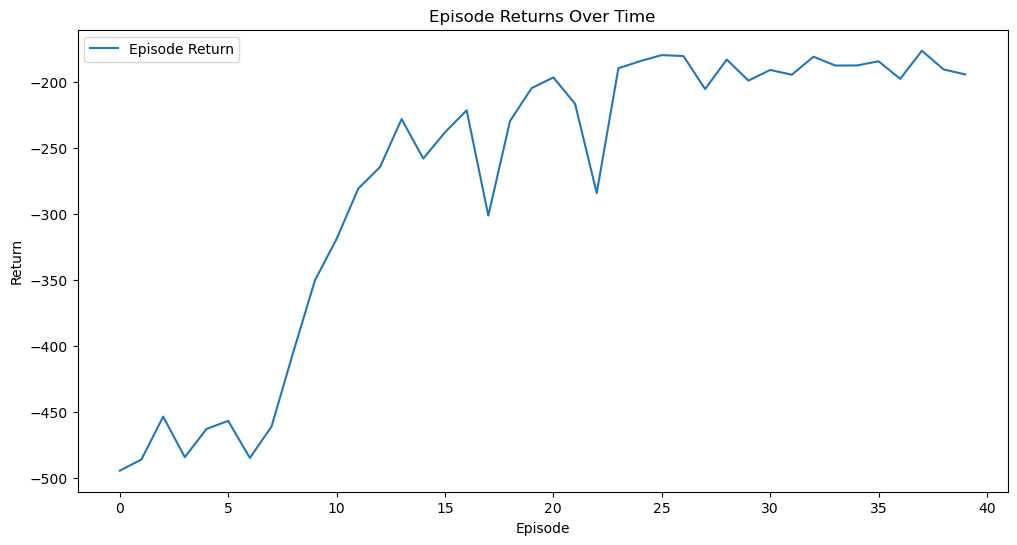

In [35]:
import warnings
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3 import A2C
from stable_baselines3 import PPO
from sb3_contrib import RecurrentPPO

# Define the environment
env = LearningFinMovement(False, False)


# Path where the checkpoints are saved
checkpoint_dir = rl_models_dir
checkpoint_prefix = 'y_ppo_fin_movement'

def find_latest_checkpoint(directory, prefix):
    checkpoints = [f for f in os.listdir(directory) if f.startswith(prefix)]

    if not checkpoints:
        return None
    checkpoints.sort(key=lambda x: int(x.split('_')[4].split('.')[0]), reverse=True)
    return os.path.join(directory, checkpoints[0])

latest_checkpoint = find_latest_checkpoint(checkpoint_dir, checkpoint_prefix)

if latest_checkpoint:
    print(f"Loading model from checkpoint: {latest_checkpoint}")
    model = RecurrentPPO.load(latest_checkpoint, env=env, n_steps=32, gamma=0.8) # ent_coef=0.001
else:
    print("No checkpoint found. Starting from scratch.")
    model = RecurrentPPO("MlpLstmPolicy", env, verbose=1, n_steps=32, gamma=0.8)
    policy_kwargs = dict(
                lstm_hidden_size=64,
                n_lstm_layers=3,
                net_arch=[64]
            )


checkpoint_callback = CheckpointCallback(save_freq=1000, save_path=checkpoint_dir, name_prefix=checkpoint_prefix)
warnings.filterwarnings("ignore", message="X does not have valid feature names")
model.learn(total_timesteps=10000, callback=checkpoint_callback)  # Adjust the total timesteps as needed
plot_returns(env.episode_returns)

model.save("final_model_ppo_fin_movement")